#Data loading and Dataset Preparation:

## All necessary Imports

In [ ]:
!pip install segmentation_models_pytorch > /dev/null ;
import sys  # Access to interpreter variables and functions
import cv2  # Computer vision library
import torch  # Deep learning library
import torchvision  # Computer vision library
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis library
from torch import nn  # Neural network building blocks and functions
from PIL import Image  # Image file manipulation library
from tqdm import tqdm  # Progress bar library
import matplotlib.pyplot as plt  # Data visualization library
from torch.utils.data import Dataset  # Interface for loading and processing data
from torch.utils.data import DataLoader  # Iterator for loading and batching data
import segmentation_models_pytorch as smp  # Library for semantic segmentation
from torchvision.transforms import transforms  # Image and data transformation functions
from sklearn.model_selection import train_test_split  # Function for splitting data into training and testing sets


##Dataframe with Input and Label pictures path location

In [ ]:
import os
import pandas as pd


input_folder = 'inputs'
output_folder = 'labels'

# Get list of input and output files
input_files = []
output_files = []
for file in os.listdir(input_folder):
    if file.endswith('.jpg') or file.endswith('.png'):
        input_files.append(os.path.join(input_folder, file))
        output_files.append(os.path.join(output_folder, file.replace('.jpg', '.jpg').replace('.png', '_annotated.png')))

# Check if the number of input and output files match
if len(input_files) != len(output_files):
    raise ValueError('The number of input and output files does not match.')

# Create DataFrame with file paths
data = {'OriginalImages': input_files,
        'AnnotatedImages': output_files}
df = pd.DataFrame(data)
df.tail()

--2023-04-29 00:54:37--  https://drive.google.com/drive/folders/1kc9Uk1Pc2XSAe_txNcsh5Q5zx-2mlFcB?usp=share_link
Resolving drive.google.com (drive.google.com)... 172.217.194.100, 172.217.194.139, 172.217.194.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/drive/MyDrive/input_folder/1kc9Uk1Pc2XSAe_txNcsh5Q5zx-2mlFcB?usp=share_link.1’

1kc9Uk1Pc2XSAe_txNc     [  <=>               ] 541.23K  1.39MB/s    in 0.4s    

2023-04-29 00:54:38 (1.39 MB/s) - ‘/content/drive/MyDrive/input_folder/1kc9Uk1Pc2XSAe_txNcsh5Q5zx-2mlFcB?usp=share_link.1’ saved [554217]



,OriginalImages,AnnotatedImages


## picture_view(), classIndexMask(), and mask_to_rgb() functions


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import cv2

def picture_view(image, mask, pred_image=None):
    if pred_image is None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.set_title('Original Image')
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')

        ax2.set_title('Ground Truth Mask')
        ax2.imshow(mask_to_rgb(mask))

    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

        ax1.set_title('Original Image')
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')

        ax2.set_title('Ground Truth Mask')
        ax2.imshow(mask_to_rgb(mask))

        ax3.set_title('Predicted Mask')
        ax3.imshow(mask_to_rgb(pred_image))


def mask_to_rgb(mask):
    color_map = {
        0: (0, 0, 0),  # Background
        1: (255, 0, 0),
        2: (0, 255, 0),
        3: (0, 0, 255) # Class 5
    }

    # Threshold for converting RGB values to specific values
    threshold = 10

    # Check if any RGB value is close to (255, 0, 0), (0, 255, 0) or (0, 0, 255)
    for k in color_map.keys():
        if abs(color_map[k][0] - 255) < threshold and color_map[k][1] == 0 and color_map[k][2] == 0:
            color_map[k] = (255, 0, 0)
        elif abs(color_map[k][1] - 255) < threshold and color_map[k][0] == 0 and color_map[k][2] == 0:
            color_map[k] = (0, 255, 0)
        elif abs(color_map[k][2] - 255) < threshold and color_map[k][0] == 0 and color_map[k][1] == 0:
            color_map[k] = (0, 0, 255)

    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()

    # Create a new numpy array to hold the RGB mask
    h, w = mask.shape[1:]
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for row in range(h):
        for column in range(w):
            class_index = mask[0][row][column]
            rgb_mask[row][column] = color_map[class_index]

    return rgb_mask
def classIndexMask(mask):
    import numpy as np
    from PIL import Image

    # Define a dictionary mapping RGB color values to class indices
    color_to_class = {
      (0, 0, 0): 0,      # Black pixel represents background
      (254, 0, 0): 1,
      (0, 255, 1):2,
      (0, 0, 254):3 # Blue pixel represents Pole
    }
    # Load a masked image in RGB format
    mask_image = Image.open(mask)
    mask_image = mask_image.resize((256, 256))

    # Convert the RGB image to a numpy array
    mask_array = np.array(mask_image)

    # Create a new numpy array to hold the class index mask
    class_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)

    # Iterate over each RGB color value and map it to a class index
    for color, class_idx in color_to_class.items():
      # Find the indices in the numpy array where the RGB color value matches the dictionary key
      color_indices = np.where(np.all(mask_array == color, axis=-1))
      # Assign the corresponding class index to the pixels at those indices
      class_indices[color_indices] = class_idx
    return class_indices

## Split the datframe into train, test, and validation set

In [ ]:
from sklearn.model_selection import ShuffleSplit

# Shuffle the indices
indices = np.arange(len(df))
np.random.shuffle(indices)

# Split into training, validation, and test sets
split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=101)
train_indices, test_val_indices = next(split.split(indices))

split = ShuffleSplit(n_splits=1, test_size=0.5, random_state=101)
test_indices, val_indices = next(split.split(test_val_indices))

# Create dataframes for each set
train_data = df.iloc[train_indices]
test_data = df.iloc[test_indices]
val_data = df.iloc[val_indices]
# train_data

,OriginalImages,AnnotatedImages
120,/content/drive/MyDrive/inputs/105.jpg,/content/drive/MyDrive/labels/105.jpg
108,/content/drive/MyDrive/inputs/91.jpg,/content/drive/MyDrive/labels/91.jpg
57,/content/drive/MyDrive/inputs/49.jpg,/content/drive/MyDrive/labels/49.jpg
82,/content/drive/MyDrive/inputs/70.jpg,/content/drive/MyDrive/labels/70.jpg
118,/content/drive/MyDrive/inputs/104.jpg,/content/drive/MyDrive/labels/104.jpg
...,...,...
63,/content/drive/MyDrive/inputs/52.jpg,/content/drive/MyDrive/labels/52.jpg
70,/content/drive/MyDrive/inputs/58.jpg,/content/drive/MyDrive/labels/58.jpg
81,/content/drive/MyDrive/inputs/67.jpg,/content/drive/MyDrive/labels/67.jpg
11,/content/drive/MyDrive/inputs/10.jpg,/content/drive/MyDrive/labels/10.jpg


## CustomImage Dataset Definition

In [ ]:
import albumentations as A

class CustomImageDataset(Dataset):

    def __init__(self, df):
        """
        Custom dataset for loading and preprocessing images and masks.

        Args:
        - df (pandas.DataFrame): DataFrame containing the file paths of original images and annotated images.
        """
        self.df=df
        # Resize the input images to the desired size
        self.transforms = transforms.Resize((256, 256))
        self.augmentations = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.GaussNoise(p=0.2)
        ])

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self ,idx):
        """
        Returns the input image and corresponding mask for a given index.

        Args:
        - idx (int): Index of the sample to be retrieved.

        Returns:
        - original_image (torch.Tensor): Preprocessed input image tensor.
        - mask (torch.Tensor): Preprocessed mask tensor.
        """
        # Get file paths for input image and corresponding mask
        row = self.df.iloc[idx]
        dir = "/content/drive/MyDrive/"
        image_path = row.OriginalImages.replace('\\', '/')
        mask_path  =  row.AnnotatedImages.replace('\\', '/')
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = classIndexMask(mask_path)
        mask =np.expand_dims(mask ,axis=-1)#(h,w,1)

        # Apply augmentations to image and mask
        augmented = self.augmentations(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

        #(h,w,c) -> (c,h,w)
        image = np.transpose(image ,(2,0,1)).astype(np.float32)
        mask = np.transpose(mask ,(2,0,1)).astype(np.float32)
        original_image = self.transforms(torch.Tensor(image))
        original_image = original_image/255.0 # normalizing original image tensor [0,1] range
        return original_image, torch.Tensor(mask)

In [ ]:
train_data_set = CustomImageDataset(train_data)
valid_data_set = CustomImageDataset(val_data)
test_data_set = CustomImageDataset(test_data)
train_dataloader = DataLoader(train_data_set, batch_size=8, shuffle=True)
val_dataloader = DataLoader(valid_data_set, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data_set, batch_size=8, shuffle=True)
image, label = next(iter(train_dataloader))
print('The size of input image is:', image.shape)
print('The size of label image is:',label.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The size of input image is: torch.Size([8, 3, 256, 256])
The size of label image is: torch.Size([8, 1, 256, 256])


# PSPnet Model Definition and training:

## Model definition:-

In [ ]:
# sys.path.append('/content/drive/MyDrive/')
DEVICE = 'cpu'
device = DEVICE
EPOCHS = 10
LR = 0.01
BATCH_SIZE = 8
ENCODER = 'resnet50'
WEIGHTS = 'imagenet'
class PSPNetModel(nn.Module):
    def __init__(self):
        super(PSPNetModel, self).__init__()

        # Initialize the PSPNet model with pre-trained encoder and weights
        self.arc = smp.PSPNet(
            encoder_name=ENCODER, # Encoder architecture name
            encoder_weights='imagenet', # Path to pre-trained weights
            in_channels=3, # Number of input channels (RGB image)
            classes=4, # Number of output classes (including background)
            activation='softmax' # Activation function for output
        )

    def forward(self, images, masks=None):
        # Pass input images through the model to get logits
        logits = self.arc(images)

        # If ground truth masks are provided, calculate and return the loss
        if masks is not None:
            masks = masks.squeeze(1) # Remove the channel dimension from ground truth masks
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, masks)
            return logits, loss

        # If no ground truth masks are provided, only return the logits
        return logits


In [ ]:
def train(data_loader, model, optimizer):
    model.train()
    total_loss = 0
    tk0 = tqdm(data_loader, total=len(data_loader))
    for i, (images, masks) in enumerate(tk0):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = masks.long()  # Convert to integer tensor
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.mean().backward()
        optimizer.step()
        total_loss += loss.item()
        tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)

def validate(data_loader, model):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        tk0 = tqdm(data_loader, total=len(data_loader))
        for i, (images, masks) in enumerate(tk0):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            masks = masks.long()  # Convert to integer tensor
            logits, loss = model(images, masks)
            total_loss += loss.item()
            tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)

In [ ]:
model = PSPNetModel()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))

In [ ]:
# best_valid_loss = float('inf') # Initialize with a very high value
# num_epochs = 10
# for epoch in range(1, num_epochs+1):
#     train_loss = train(train_dataloader, model, optimizer)
#     valid_loss = validate(val_dataloader, model)

#     if valid_loss < best_valid_loss:
#         torch.save(model.state_dict(), '/content/drive/MyDrive/PSPnet.pth')
#         print("Model saved!")
#         best_valid_loss = valid_loss

#     print(f"Epoch [{epoch}/{num_epochs}] Train Loss: {train_loss:.4f} | Val. Loss: {valid_loss:.4f}")


  0%|          | 0/13 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
# model.load_state_dict(torch.load(r'/content/drive/MyDrive/PSPnet.pth', map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


torch.Size([1, 4, 256, 256])


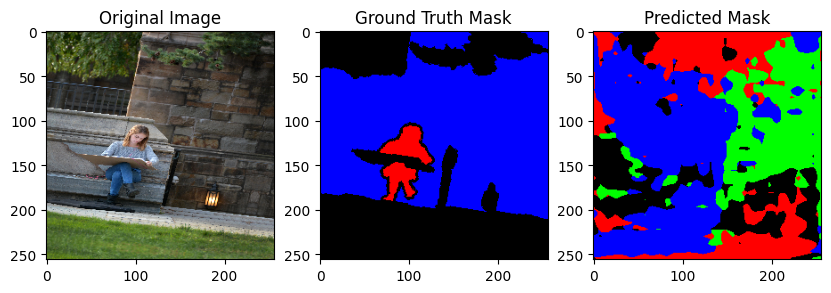

In [ ]:
# idx = 6
# image, mask = train_data_set[idx]
# logits_mask = model(image.to(DEVICE).unsqueeze (0)) #(C, H, W) -> (1, C, H, W)
# print(logits_mask.shape)
# pred_mask_prob = torch.softmax(logits_mask, dim=1)  # (batch_size, num_classes, height, width)
# _, pred_mask = torch.max(pred_mask_prob, dim=1)
# picture_view(image, mask, pred_mask)

In [ ]:
import matplotlib.pyplot as plt

def train(data_loader, model, optimizer):
    model.train()
    total_loss = 0
    tk0 = tqdm(data_loader, total=len(data_loader))
    for i, (images, masks) in enumerate(tk0):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = masks.long()  # Convert to integer tensor
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.mean().backward()
        optimizer.step()
        total_loss += loss.item()
        tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)

def validate(data_loader, model):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        tk0 = tqdm(data_loader, total=len(data_loader))
        for i, (images, masks) in enumerate(tk0):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            masks = masks.long()  # Convert to integer tensor
            logits, loss = model(images, masks)
            total_loss += loss.item()
            tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)

def visualize(train_losses, valid_losses, hyperparam, hyperparam_name):
    plt.plot(hyperparam, train_losses, label='Training Loss')
    plt.plot(hyperparam, valid_losses, label='Validation Loss')
    plt.xlabel(hyperparam_name)
    plt.ylabel('Loss')
    plt.title(f'Effect of {hyperparam_name} on Loss')
    plt.legend()
    plt.show()

# Define hyperparameters to test
lr_list = [0.001, 0.01, 0.1]
batch_size_list = [8, 16, 32]
optimizers = {'Adam': torch.optim.Adam, 'SGD': torch.optim.SGD}

# Initialize empty lists to store results
train_losses = []
valid_losses = []
lrs = []
batch_sizes = []
optimizer_names = []

# Loop through different hyperparameters
for lr in lr_list:
    for batch_size in batch_size_list:
        for optimizer_name, optimizer_fn in optimizers.items():
            # Create model, optimizer, and data loaders
            model = PSPNetModel()
            model.to(DEVICE)
            optimizer = optimizer_fn(model.parameters(), lr=lr)
            train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(valid_data_set, batch_size=batch_size, shuffle=False)

            # Train the model
            best_valid_loss = float('inf') # Initialize with a very high value
            num_epochs = 10
            for epoch in range(1, num_epochs+1):
                train_loss = train(train_dataloader, model, optimizer)
                valid_loss = validate(val_dataloader, model)

                if valid_loss < best_valid_loss:
                    torch.save(model.state_dict(), 'PSPnet.pth')
                    print("Model saved!")
                    best_valid_loss = valid_loss

                print(f"Epoch [{epoch}/{num_epochs}] Train Loss: {train_loss:.4f} | Val. Loss: {valid_loss:.4f}")

            # Save results
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            lrs.append(lr)
            batch_sizes.append(batch_size)
            optimizer_names.append(optimizer_name)

            # Visualize results
            # visualize(train_losses, valid_losses, lrs, 'Learning Rate')
            # visualize(train_losses, valid_losses, batch_sizes, 'Batch Size')
            # visualize(train_losses, valid_losses, optimizer_names, 'Optimizer')


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|████

Model saved!
Epoch [1/10] Train Loss: 1.0859 | Val. Loss: 1.0400


100%|██████████| 2/2 [00:10<00:00,  5.35s/it, loss=0.959]


Model saved!
Epoch [2/10] Train Loss: 1.0057 | Val. Loss: 0.9587


100%|██████████| 2/2 [00:21<00:00, 10.54s/it, loss=1.19]


Epoch [3/10] Train Loss: 0.9882 | Val. Loss: 1.1902


100%|██████████| 2/2 [00:14<00:00,  7.35s/it, loss=0.971]


Epoch [4/10] Train Loss: 0.9934 | Val. Loss: 0.9714


100%|██████████| 2/2 [00:16<00:00,  8.15s/it, loss=0.956]


Model saved!
Epoch [5/10] Train Loss: 0.9872 | Val. Loss: 0.9563


 69%|██████▉   | 9/13 [01:17<00:30,  7.52s/it, loss=0.963]